In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

Using TensorFlow backend.
/home/karan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/karan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/karan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/karan/.local/lib/python3.6/site-packages/tensorflow/python/fra

In [2]:
FAST_RUN = True
IMAGE_WIDTH=50
IMAGE_HEIGHT=50
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

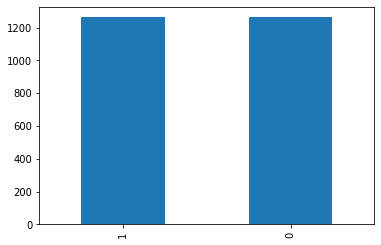

In [3]:
filenames = os.listdir("./train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'next':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.head()
df.tail()
df['category'].value_counts().plot.bar()

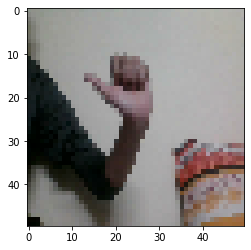

In [4]:
sample = random.choice(filenames)
image = load_img("./train/"+sample)
plt.imshow(image)

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [6]:
model = Sequential()
model.add(Conv2D(32, (2, 2), input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))) 
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
  
model.add(Conv2D(32, (2, 2))) 
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
  
model.add(Conv2D(64, (2, 2))) 
model.add(Activation('relu')) 
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2, 2))) 
  
model.add(Flatten()) 
model.add(Dense(64)) 
model.add(Activation('relu')) 
model.add(Dropout(0.5)) 
model.add(Dense(2)) 
model.add(Activation('sigmoid')) 

In [7]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 49, 49, 32)        416       
_________________________________________________________________
activation_1 (Activation)    (None, 49, 49, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 32)        4128      
_________________________________________________________________
activation_2 (Activation)    (None, 23, 23, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 32)        0         
__________________________

In [8]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]
df["category"] = df["category"].replace({0: 'pause', 1: 'next'})

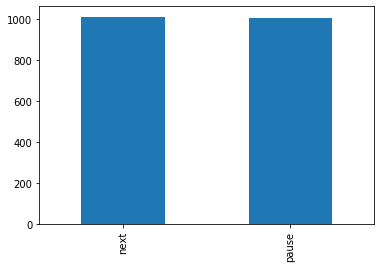

In [9]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

train_df['category'].value_counts().plot.bar()
validate_df['category'].value_counts().plot.bar()
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=30

In [10]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
) 

Found 2019 validated image filenames belonging to 2 classes.
Found 505 validated image filenames belonging to 2 classes.


In [11]:
epochs=1 if FAST_RUN else 10
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

model.save_weights("model.h5")


Epoch 1/1
67/67 [==============================] - 5s 74ms/step - loss: 0.2272 - accuracy: 0.9037 - val_loss: 0.0058 - val_accuracy: 1.0000


/home/karan/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


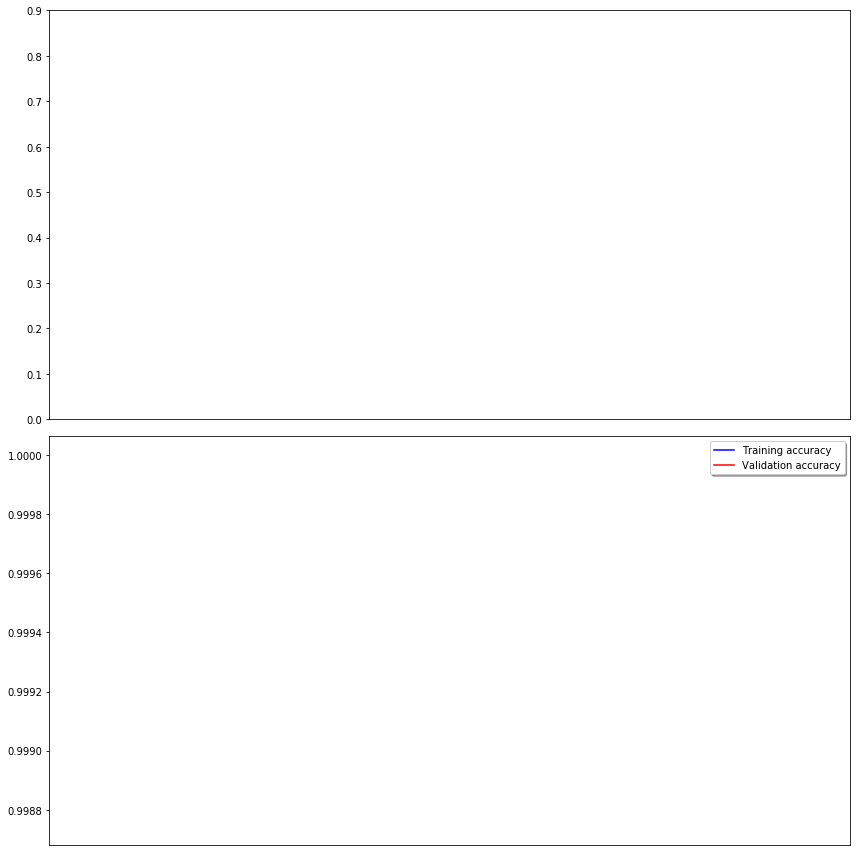

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [18]:
test_filenames = os.listdir('./test1')
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

Found 1919 validated image filenames.


------------------Testing Data---------------------
     filename category
0   02150.png     next
1   02183.png     next
2    1666.png    pause
3    1282.png    pause
4    1995.png    pause
5   02191.png     next
6   01733.png     next
7    1770.png    pause
8    1553.png    pause
9    1690.png    pause
10  01568.png     next
11  01503.png     next
12   1263.png    pause
13   1390.png    pause
14   1348.png    pause
15   1312.png    pause
16  01930.png     next
17  01431.png     next


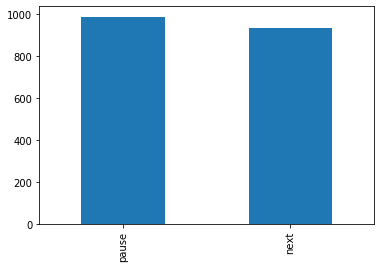

In [19]:
test_df['category'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
# test_df['category'] = test_df['category'].replace({ 'next': 1, 'pause': 0 })
test_df['category'].value_counts().plot.bar()

sample_test = test_df.head(18)
print('------------------Testing Data---------------------')
print(sample_test)